#### R包的导入及数据的获取与预处理

In [9]:
options (warn = -1)

In [10]:
library(lubridate)
library(xts)
library(quantmod)
library(Tushare)
library(TSA)
library(fUnitRoots)
library(urca)
library(fBasics)
library(forecast)
# 数据获取
api<-pro_api(token="731ee2eafa47ae6b8c98993e8b30001b51bd3085cd69d63870e745c9")
hxgf<-api(api_name ='daily',ts_code ='300427.SZ',start_date='20170101',end_date='20220101')
# 时序类型转换
time<-as.Date(ymd(hxgf$trade_date))
hxgf_close_price<-xts(hxgf$close,order.by=time)
hxgf_close_return<-dailyReturn(hxgf_close_price,type ="arithmetic")[-1]#计算红相股份简单收益率
new_time<-index(hxgf_close_price)[965:1207]
hxgf_close_logreturn<-dailyReturn(hxgf_close_price,type ="log")[-1]#计算红相股份对数收益率

# 运用选取的股票进行线性模型构建与分析

## 给出价格序列和收益率序列的样本自相关图和偏自相关图

### 绘制自相关图

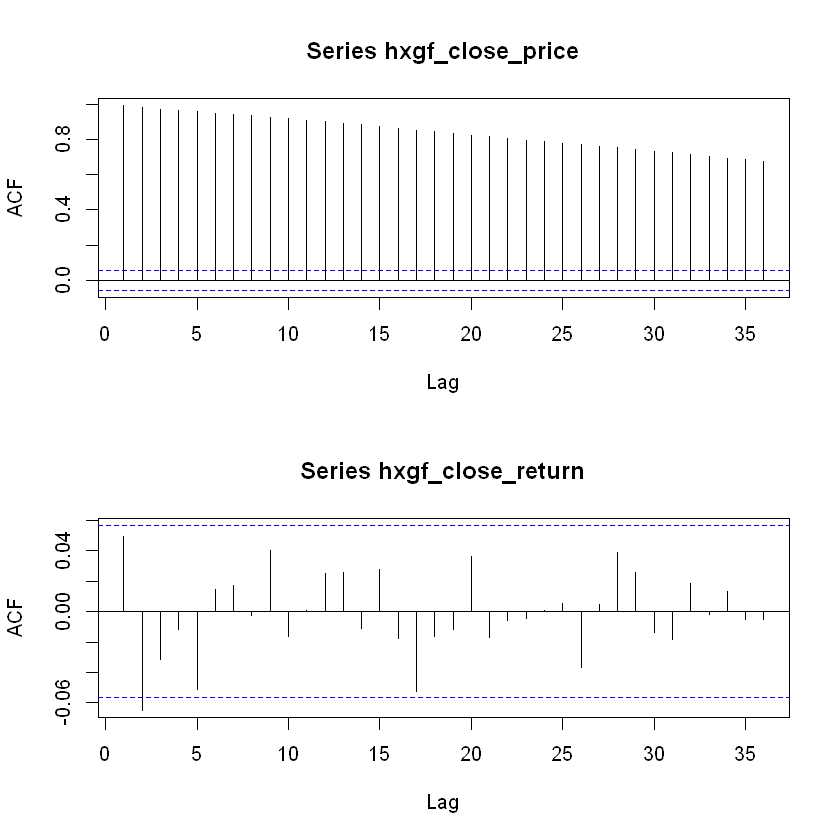

In [11]:
par(mfrow=c(2,1))
acf(hxgf_close_price,lag=36)
acf(hxgf_close_return,lag=36)

### 绘制偏自相关图

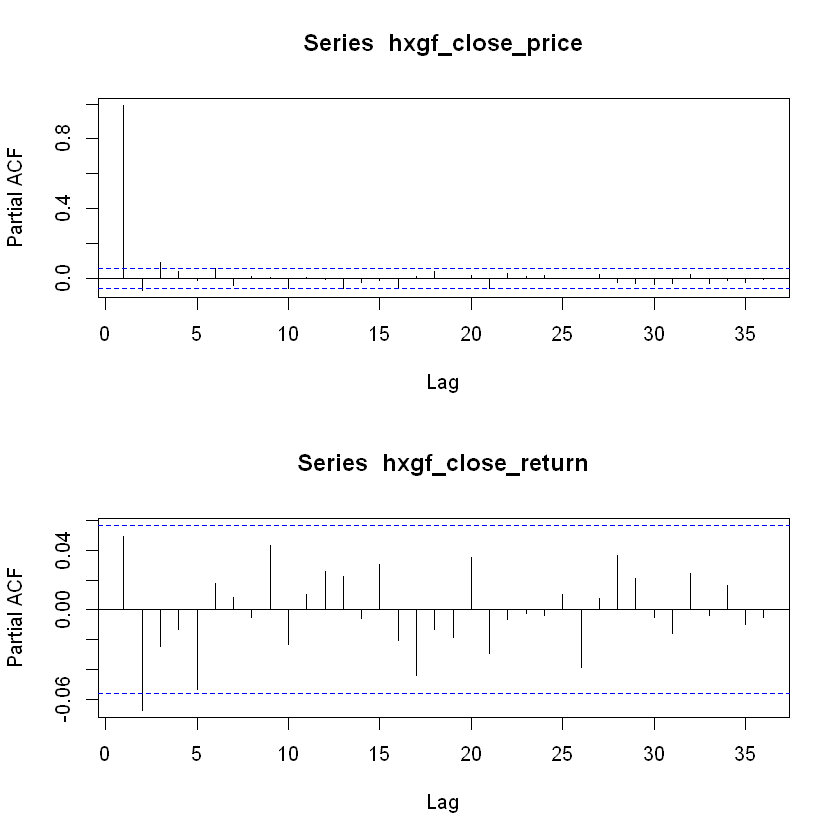

In [12]:
par(mfrow=c(2,1))
pacf(hxgf_close_price,lag=36)
pacf(hxgf_close_return,lag=36)

## 对价格序列和收益率序列进行混成检验

In [13]:
Box.test(hxgf_close_price,type='Ljung-Box')


	Box-Ljung test

data:  hxgf_close_price
X-squared = 1187.5, df = 1, p-value < 2.2e-16


#### 混成检验p值小于0.05，拒绝原假设，即认为价格序列存在序列相关

In [14]:
Box.test(hxgf_close_return,type='Ljung-Box')


	Box-Ljung test

data:  hxgf_close_return
X-squared = 2.9163, df = 1, p-value = 0.08769


#### 混成检验p值小于0.1，在10%的置信水平下拒绝原假设，即认为收益率序列存在序列相关

## 运用本模块讲授的的多种方法验证该只股票的价格波动是否符合有效市场假说

### 方法一：直接以价格序列为研究对象的检验方法：计算并检验相隔k期的股价的自相关系数


	Box-Ljung test

data:  hxgf_close_price
X-squared = 1187.5, df = 1, p-value < 2.2e-16


	Box-Ljung test

data:  hxgf_close_price
X-squared = 2350.9, df = 2, p-value < 2.2e-16


	Box-Ljung test

data:  hxgf_close_price
X-squared = 3494.4, df = 3, p-value < 2.2e-16


	Box-Ljung test

data:  hxgf_close_price
X-squared = 4620.7, df = 4, p-value < 2.2e-16


	Box-Ljung test

data:  hxgf_close_price
X-squared = 5729.3, df = 5, p-value < 2.2e-16



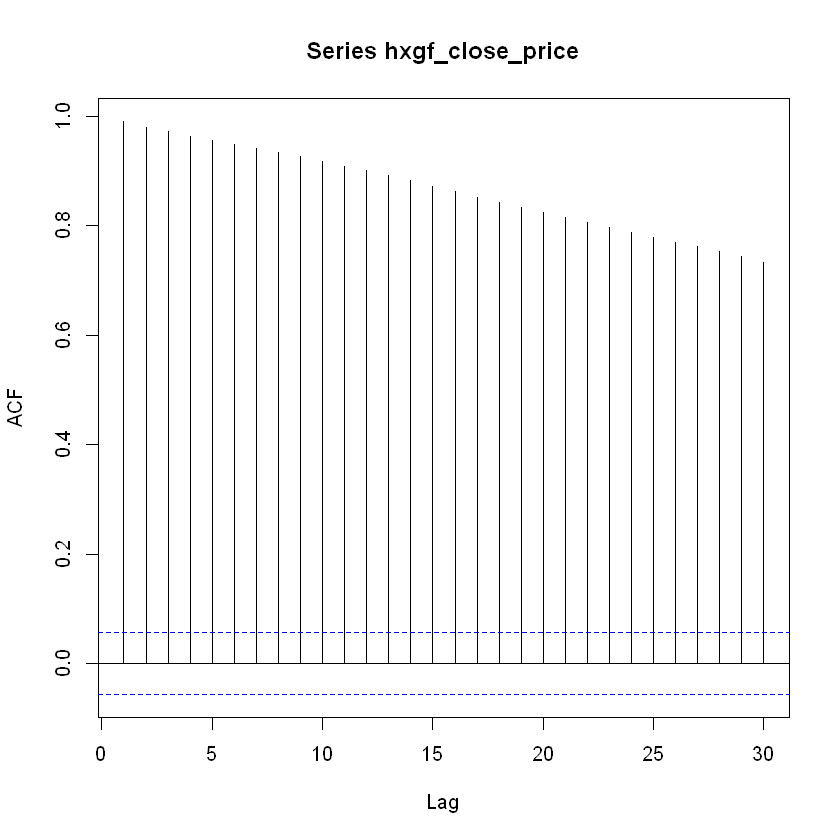

In [15]:
acf(hxgf_close_price)
for (i in 1:5){print( Box.test(hxgf_close_price,type="Ljung-Box",lag=i))}

#### 从自相关图来看，即使高阶滞后项依旧有较大的相关性，同时Box-Ljung检验计算所得的p值显著小于临界值，拒绝原假设，红相股份的股票历史价格存在序列相关，即红相股份的交易市场未达到弱势有效

### 方法二：建立股价序列的自回归模型，并对其系数进行显著性检验

In [16]:
hxgf_ar<-ar(hxgf_close_price,method = 'yule-walker')
adfTest(hxgf_ar$resid,type="ct")
Box.test(hxgf_ar$resid,lag=12,type="Ljung-Box")


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -24.5631
  P VALUE:
    0.01 

Description:
 Fri Apr 28 16:09:39 2023 by user: 20392



	Box-Ljung test

data:  hxgf_ar$resid
X-squared = 7.0541, df = 12, p-value = 0.854


#### 残差检验：拒绝adf检验，没有单位根；接受Box-Ljung检验，序列没有自相关性，残差序列是平稳的序列。红相股份达到弱势有效

### 方法三：对价格序列或其对数序列进行单位根检验，以判断其是否符合随机游走

In [17]:
adfTest(hxgf_close_price,type="ct")
adfTest(log(hxgf_close_price),type="ct")


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -2.4826
  P VALUE:
    0.374 

Description:
 Fri Apr 28 16:09:39 2023 by user: 20392



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -2.441
  P VALUE:
    0.3916 

Description:
 Fri Apr 28 16:09:39 2023 by user: 20392


#### 价格序列及其对数序列都接受原假设，价格序列及其对数序列都存在单位根，表明其不平稳，该市场未达到弱势有效

### 方法四：以收益率序列建模并对模型的干扰项序列进行相关性检验

### 运用 ARMA 模型刻画价格或收益率序列的相关性

In [18]:
Box.test(hxgf_close_logreturn,type = "Ljung-Box")


	Box-Ljung test

data:  hxgf_close_logreturn
X-squared = 2.7489, df = 1, p-value = 0.09732


#### p值为0.09732，即在10%的置信水平下，拒绝原假设，对数收益率序列存在相关性，红相股份价格波动未达到弱势有效

#### 收益率序列

In [19]:
adfTest(hxgf_close_return,type="ct")


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -25.5579
  P VALUE:
    0.01 

Description:
 Fri Apr 28 16:09:39 2023 by user: 20392


#### adf检验拒绝原假设，不存在单位根，序列是平稳序列

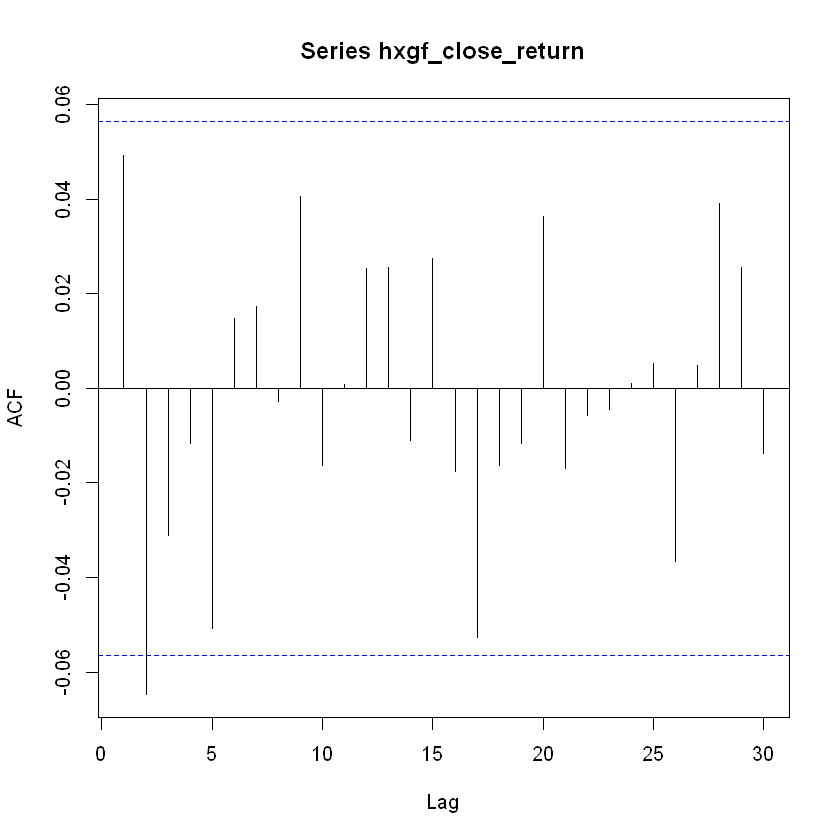

In [20]:
acf(hxgf_close_return)

#### acf图二阶拖尾

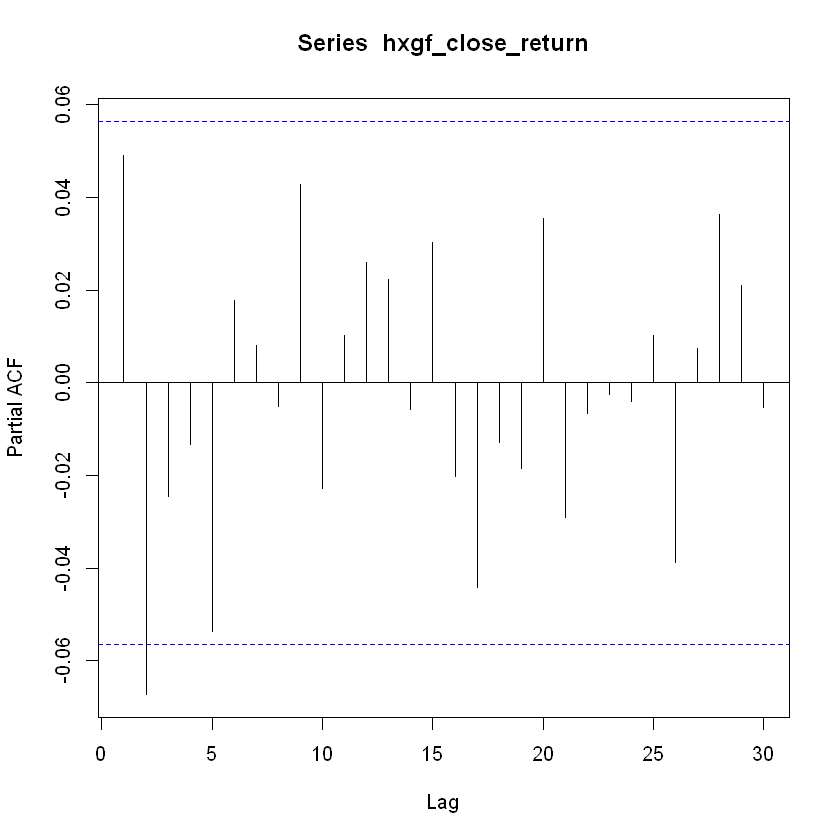

In [21]:
pacf(hxgf_close_return)

#### pacf图二阶拖尾

#### 建立ARMA(2,2)模型，来刻画收益率序列的相关性


Call:
arima(x = hxgf_close_return, order = c(2, 0, 2), fixed = c(NA, NA, NA, NA, 0))

Coefficients:
         ar1      ar2      ma1      ma2  intercept
      0.5164  -0.0217  -0.4666  -0.0691          0
s.e.  0.3069   0.2458   0.3063   0.2440          0

sigma^2 estimated as 0.001114:  log likelihood = 2389.22,  aic = -4770.44

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN

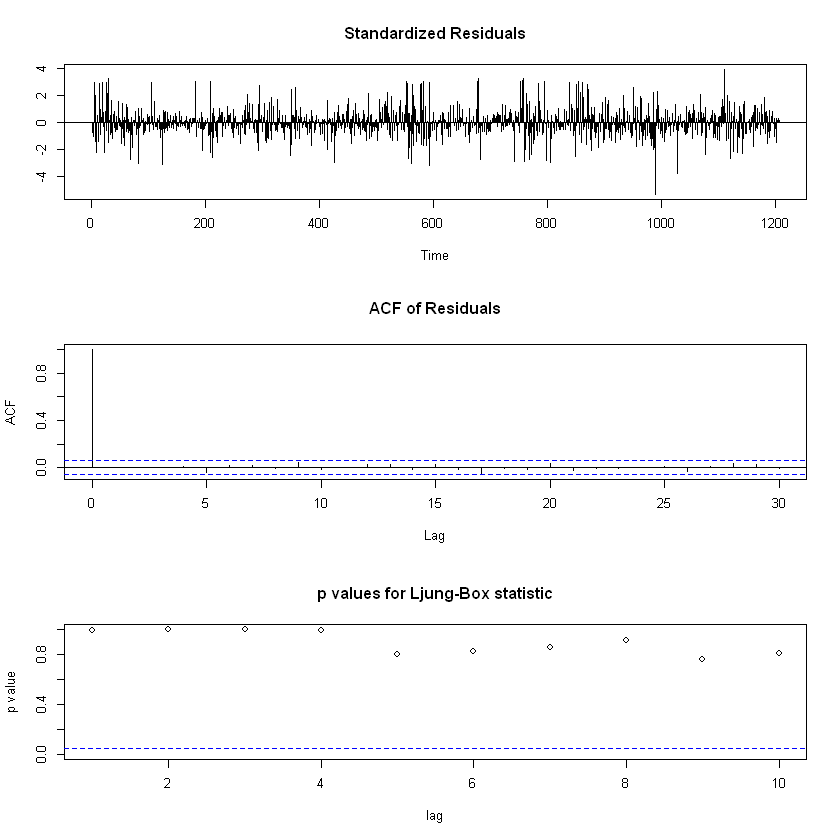

In [22]:
xiangguanxing_hxgf<-arima(hxgf_close_return,order=c(2,0,2),fixed=c(NA,NA,NA,NA,0))
summary(xiangguanxing_hxgf)
tsdiag(xiangguanxing_hxgf)

#### 从残差序列的图中来看，ACF截尾，残差序列接受BOX检验的原假设，残差序列没有序列相关，即残差序列是平稳的，ARMA（2，2）模型对收益率序列的刻画效果很好

### 构建有关价格和收益率序列的 AR(p) 模型并进行平稳性检验和模型检验

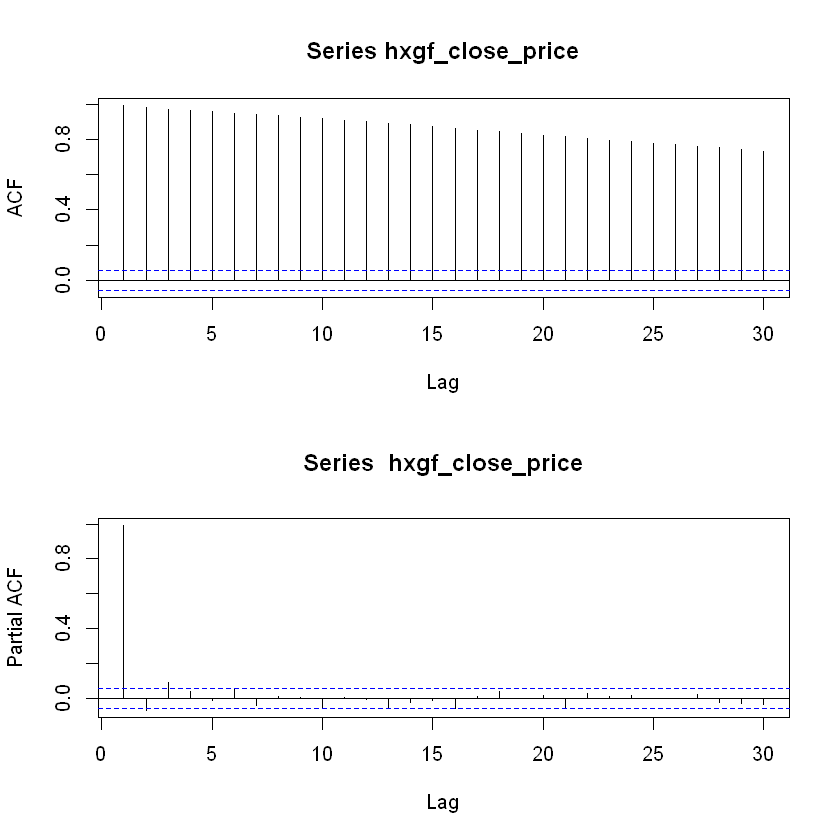

In [23]:
par(mfrow=c(2,1))
acf(hxgf_close_price)
pacf(hxgf_close_price)

#### pacf图在3阶截尾,acf图拖尾，可以建立AR(3)模型

#### 价格序列建模

[1] 1.009119 3.239177 3.239177

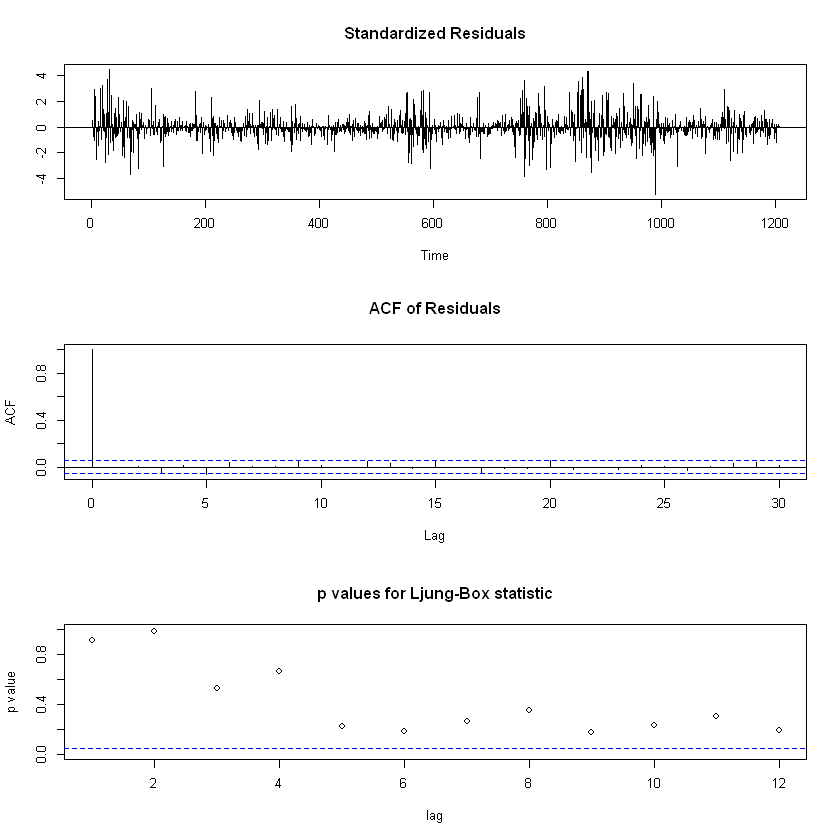

In [24]:
AR_jiage<-arima(hxgf_close_price,order = c(3,0,0))
tsdiag(AR_jiage,gof=12)
abs(polyroot(c(1,-AR_jiage$coef[1:3])))

#### 从标准化残差序列图来看：残差序列通过BOX检验，接受原假设即残差序列不存在序列相关性，且所计算的特征值均在单位圆之外，模型通过平稳性检验，残差检验通过，模型拟合效果好

#### 收益率序列建模

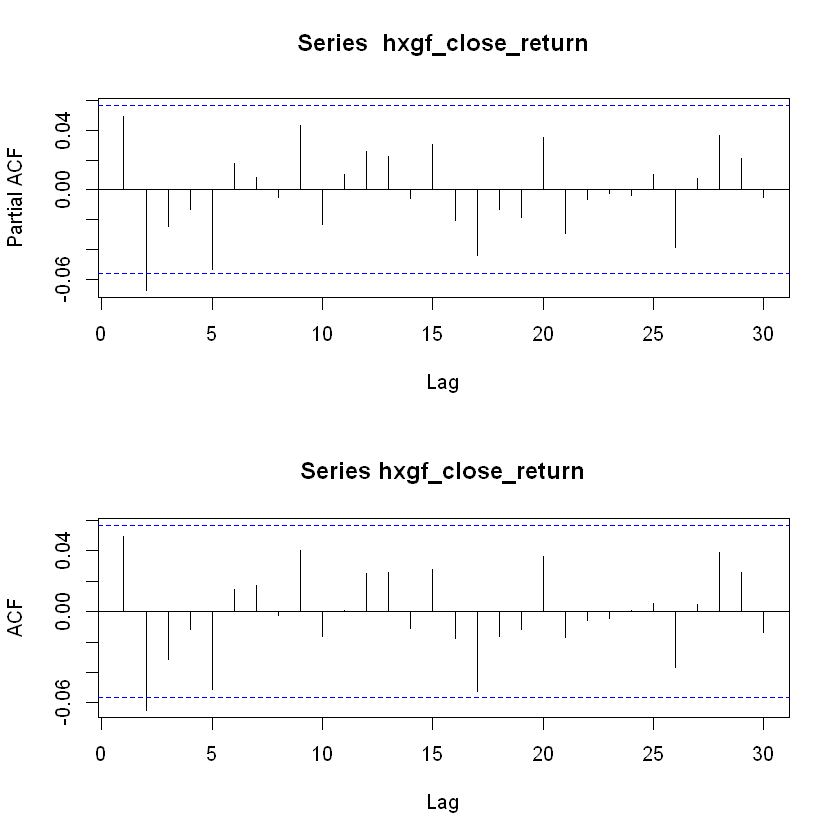

In [25]:
par(mfrow=c(2,1))
pacf(hxgf_close_return)
acf(hxgf_close_return)

#### pacf图在2阶截尾,acf图拖尾，可以建立AR(2)模型

[1] 3.858101 3.858101

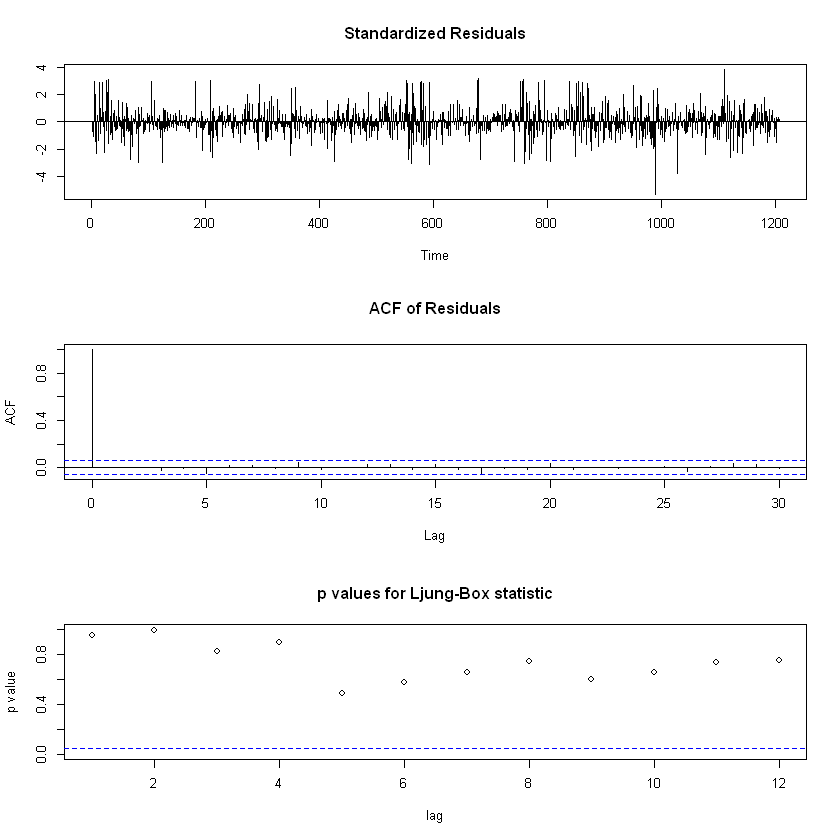

In [26]:
AR_shouyi<-arima(hxgf_close_return,order = c(2,0,0),fixed = c(NA,NA,0))
tsdiag(AR_shouyi,gof=12)
abs(polyroot(c(1,-AR_shouyi$coef[1:3])))

#### 从标准化残差序列图来看：残差序列通过BOX检验，接受原假设即残差序列不存在序列相关性，且所计算的特征值均在单位圆之外，模型通过平稳性检验，残差检验通过，模型拟合效果好

### 识别刻画价格和收益率序列的 ARMA 模型阶数并对 ARMA 模型进行参数估计与检验

#### 价格序列建模

In [27]:
m1_jiage<-eacf(hxgf_close_price,7,13)

AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 x x x x x x x x x x x  x  x  x 
1 x x o o o o o o o o o  o  o  o 
2 x x x o o o o o o o o  o  o  o 
3 x x o o o o o o o o o  o  o  o 
4 x x x o x o o o o o o  o  o  o 
5 x x x x o o o o o o o  o  o  o 
6 x x x x x o o o o o o  o  o  o 
7 x x o x x x o o o o o  o  o  o 


#### EACF识别结果表明可以建立ARMA(1,2)模型

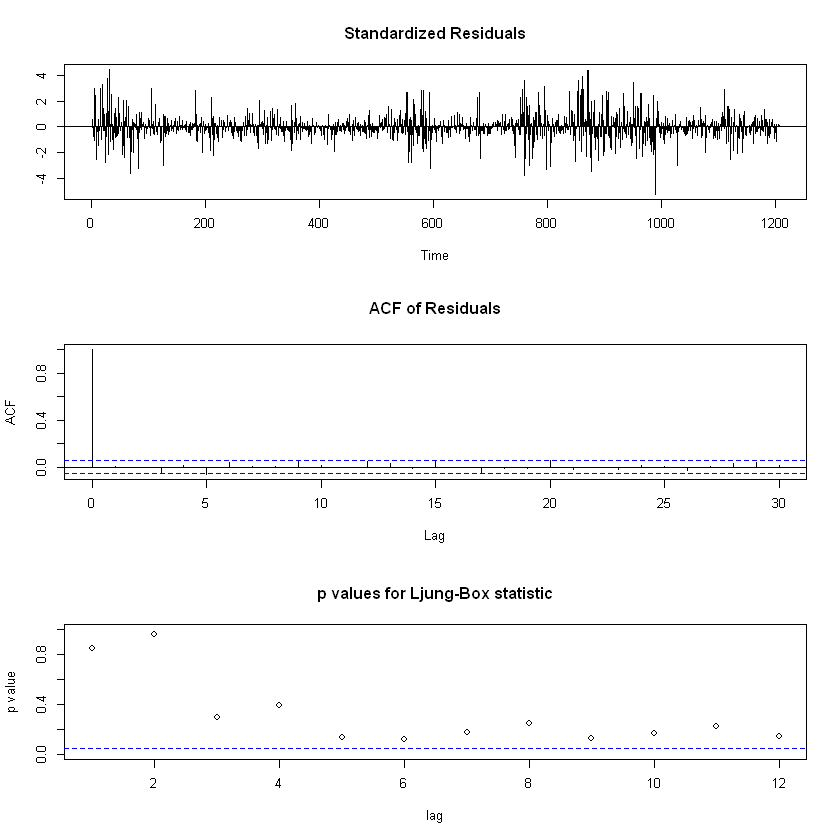

In [28]:
jiage_ARMA<-arima(hxgf_close_price,order = c(1,0,2),transform.pars = FALSE)
tsdiag(jiage_ARMA,gof=12)

#### 从标准化残差序列图来看：残差序列通过Box-Ljung检验，接受原假设即残差序列不存在序列相关性，模型通过平稳性检验，拟合效果好

#### 收益率序列建模

In [29]:
m1_shouyi<-eacf(hxgf_close_return,7,13)

AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 o x o o o o o o o o o  o  o  o 
1 x x o o o o o o o o o  o  o  o 
2 x o o o o o o o o o o  o  o  o 
3 x o x o x o o o o o o  o  o  o 
4 x x x x o o o o o o o  o  o  o 
5 x x o x x o o o o o o  o  o  o 
6 x x o x x x o o o o o  o  o  o 
7 x x x x x o x o o o o  o  o  o 


#### EACF识别结果表明可以建立ARMA(2,2)模型

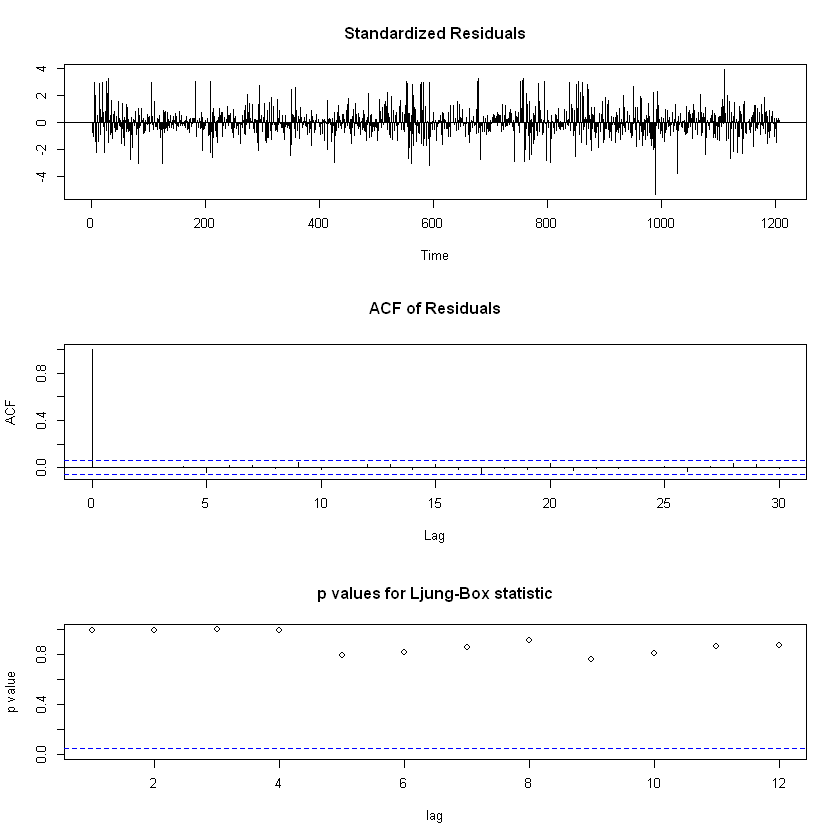

In [30]:
shouyi_ARMA<-arima(hxgf_close_return,order = c(2,0,2),transform.pars = FALSE)
tsdiag(shouyi_ARMA,gof=12)

#### 从标准化残差序列图来看：残差序列通过BOX检验，接受原假设即残差序列不存在序列相关性，模型通过平稳性检验，拟合效果好

### 运用多种方法对价格和收益率序列进行单位根检验

#### 价格序列单位根检验

#### 方法一：ADF检验

In [31]:
adfTest(hxgf_close_price,type=c('ct'))


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -2.4826
  P VALUE:
    0.374 

Description:
 Fri Apr 28 16:09:40 2023 by user: 20392


#### adf检验接受原假设，存在单位根，序列不平稳

#### 方法二：ADF检验的另一种表达

In [32]:
unitrootTest(hxgf_close_price,type=c('ct'))


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    DF: -2.4826
  P VALUE:
    t: 0.3368 
    n: 0.9564 

Description:
 Fri Apr 28 16:09:40 2023 by user: 20392


#### adf检验接受原假设，存在单位根，序列不平稳

#### 方法三：ADF检验的另一种表达

In [33]:
adf_jiage<-ur.df(hxgf_close_price,type='trend',selectlags='AIC')
summary(adf_jiage)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.02135 -0.28651 -0.01712  0.23364  2.77216 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  1.584e-01  7.369e-02   2.150   0.0317 *
z.lag.1     -9.611e-03  3.871e-03  -2.483   0.0132 *
tt          -7.830e-06  5.014e-05  -0.156   0.8759  
z.diff.lag   7.001e-02  2.879e-02   2.432   0.0152 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6049 on 1201 degrees of freedom
Multiple R-squared:  0.009333,	Adjusted R-squared:  0.006858 
F-statistic: 3.771 on 3 and 1201 DF,  p-value: 0.01037


Value of test-statistic is: -2.4826 2.0756 3.0832 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -3.96 -3.41 -3.12
p

#### 第一个统计量（-2.483）大于5%临界值（-3.41），即表明接受原假设，认为价格序列存在单位根

#### 收益率序列单位根检验

#### 方法一：ADF检验

In [34]:
adfTest(hxgf_close_return,type=c('ct'))


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -25.5579
  P VALUE:
    0.01 

Description:
 Fri Apr 28 16:09:40 2023 by user: 20392


#### adf检验拒绝原假设，不存在单位根，序列平稳

#### 方法二：ADF检验的另一种表达

In [35]:
unitrootTest(hxgf_close_return,type=c('ct'))


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    DF: -25.5579
  P VALUE:
    t: < 2.2e-16 
    n: 0.02176 

Description:
 Fri Apr 28 16:09:40 2023 by user: 20392


#### adf检验拒绝原假设，不存在单位根，序列平稳

#### 方法三：ADF检验的另一种表达

In [36]:
adf_return<-ur.df(hxgf_close_return,type='trend',selectlags='AIC')
summary(adf_return)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.178651 -0.017873 -0.000611  0.015397  0.128221 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.991e-04  1.933e-03   0.155   0.8770    
z.lag.1     -1.015e+00  3.971e-02 -25.558   <2e-16 ***
tt          -4.414e-09  2.775e-06  -0.002   0.9987    
z.diff.lag   6.733e-02  2.880e-02   2.338   0.0195 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03347 on 1200 degrees of freedom
Multiple R-squared:  0.478,	Adjusted R-squared:  0.4766 
F-statistic: 366.2 on 3 and 1200 DF,  p-value: < 2.2e-16


Value of test-statistic is: -25.5579 217.7354 326.6026 

Critical values for test statistics: 
      1pct  5pct 10pct
t

#### 第一个统计量（-25.558）小于5%临界值（-3.41），即表明拒绝原假设，认为价格序列不存在单位根

### 运用价格和收益率序列构建 ARIMA 模型并进行模型检验

#### 价格序列建模

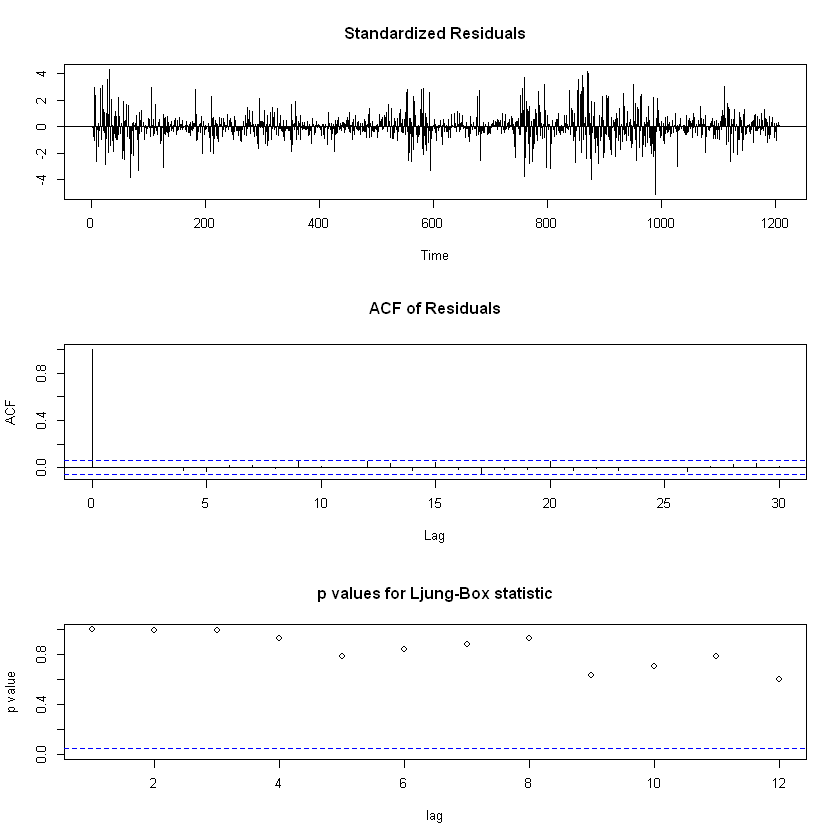

In [37]:
jiage_arima<-auto.arima(hxgf_close_price)
tsdiag(jiage_arima,gof=12)

#### 从标准化残差序列图来看：BOX检验通过，接受原假设即残差序列没有序列相关性，ARIMA模型拟合效果充分

#### 收益率序列建模

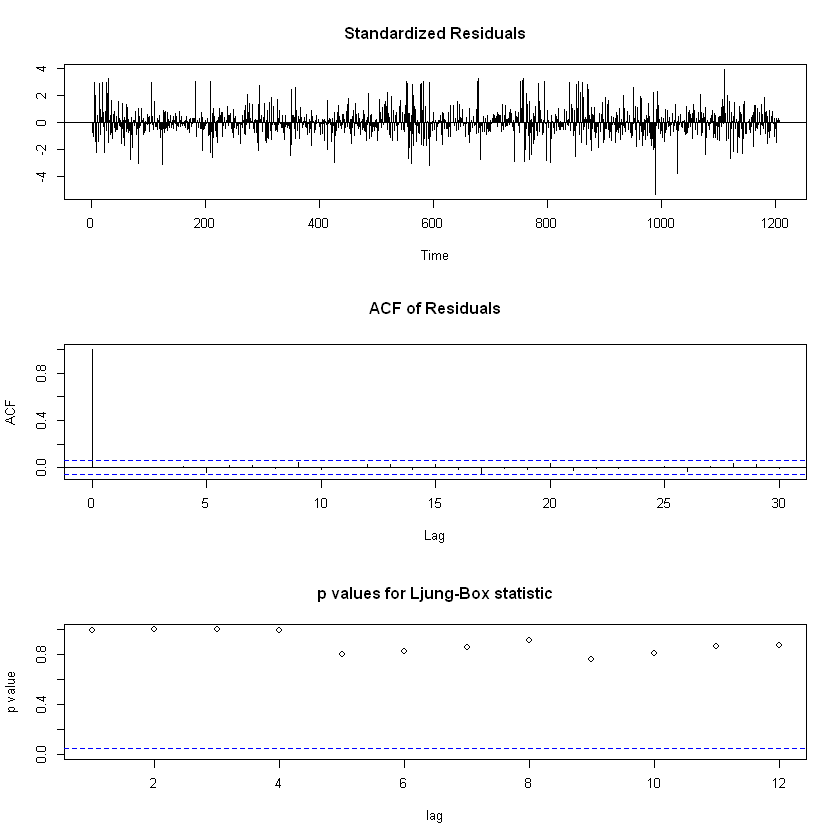

In [38]:
shouyi_arima<-arima(hxgf_close_return,order = c(2,0,2),fixed = c(NA,NA,NA,NA,0))
tsdiag(shouyi_arima,gof=12)

#### 从标准化残差序列图来看：BOX检验通过，接受原假设即残差序列没有序列相关性，ARIMA模型拟合效果充分

##### auto.arima与通过ACF和PACF选定的阶数不一样，最后选择了利用ACF与PACF识别出的结果来建模

### 运用价格和收益率序列样本期内数据构建 ARIMA 模型并预测最近一年的价格与收益率序列且给出评价标准

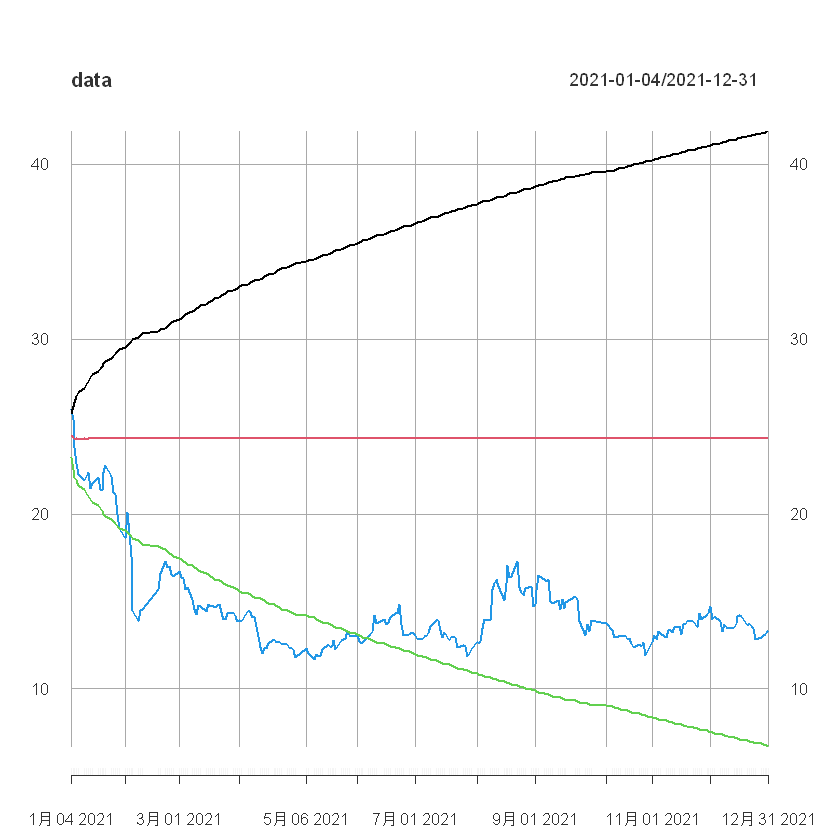

In [39]:
hxgf_close_price_window<-window(hxgf_close_price,start = "2017-01-01" ,end="2021-01-01",freq=1)
air_arima<-auto.arima(hxgf_close_price_window)
air_predict<-predict(air_arima,n.ahead=243)
m1<-xts(c(air_predict$pred)+2*c(air_predict$se),order=new_time)
m2<-xts(c(air_predict$pred),order=new_time)
m3<-xts(c(air_predict$pred)-2*c(air_predict$se),order=new_time)
m4<-window(hxgf_close_price,start = "2021-01-01")
data<-cbind(m1,m2,m3,m4)
plot(data)

#### 平均绝对预测误差

In [40]:
mean(abs(m2-window(hxgf_close_price,start = "2021-01-01")))
summary(abs(window(hxgf_close_price,start = "2021-01-01")))

[1] 9.735434

     Index            abs(window(hxgf_close_price, start = "2021-01-01"))
 Min.   :2021-01-04   Min.   :11.69                                      
 1st Qu.:2021-04-06   1st Qu.:12.93                                      
 Median :2021-07-06   Median :13.75                                      
 Mean   :2021-07-04   Mean   :14.59                                      
 3rd Qu.:2021-10-04   3rd Qu.:15.03                                      
 Max.   :2021-12-31   Max.   :26.00                                      

#### 价格的均值为14.59，预测的绝对误差为9.73，这表明模型预测效果并不很好

#### 收益率序列建模

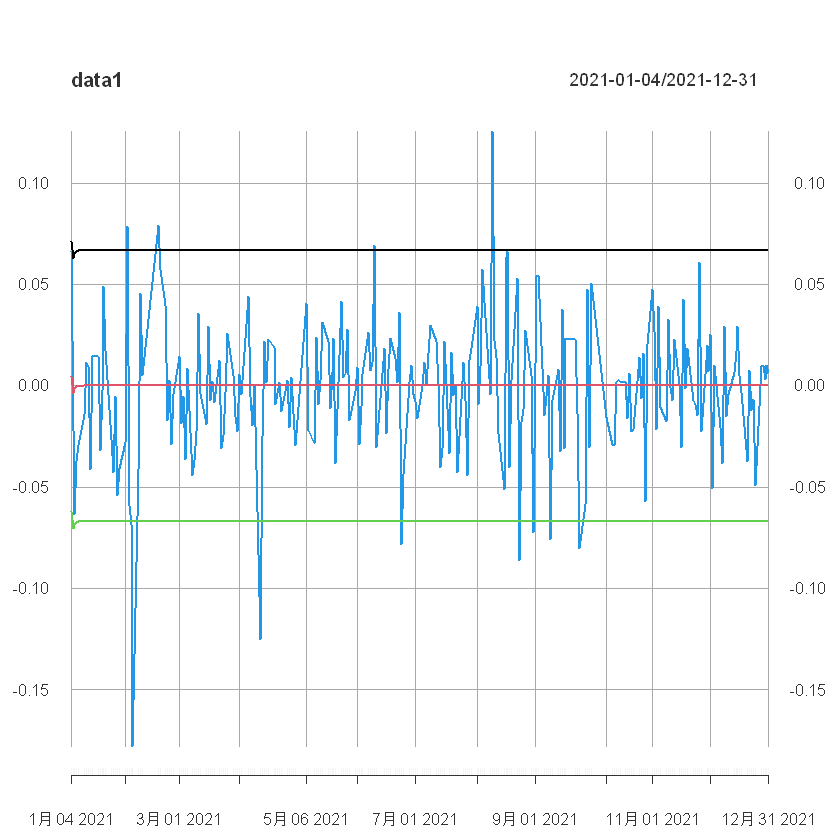

In [41]:
hxgf_close_return_window<-window(hxgf_close_return,start = "2017-01-01" ,end="2021-01-01",freq=1)
air_arima_1<-arima(hxgf_close_return_window,order = c(2,0,2),fixed = c(NA,NA,NA,NA,0))
air_predict_1<-predict(air_arima_1,n.ahead=243)
m11<-xts(c(air_predict_1$pred)+2*c(air_predict_1$se),order=new_time)
m21<-xts(c(air_predict_1$pred),order=new_time)
m31<-xts(c(air_predict_1$pred)-2*c(air_predict_1$se),order=new_time)
m41<-window(hxgf_close_return,start = "2021-01-01")
data1<-cbind(m11,m21,m31,m41)
plot(data1)

#### 平均绝对预测误差

In [42]:
mean(abs(m21-window(hxgf_close_return,start = "2021-01-01")))
summary(abs(window(hxgf_close_return,start = "2021-01-01")))

[1] 0.02462213

     Index            daily.returns     
 Min.   :2021-01-04   Min.   :0.000000  
 1st Qu.:2021-04-06   1st Qu.:0.007548  
 Median :2021-07-06   Median :0.019048  
 Mean   :2021-07-04   Mean   :0.024666  
 3rd Qu.:2021-10-04   3rd Qu.:0.034561  
 Max.   :2021-12-31   Max.   :0.177942  

#### ARIMA预测结果差，收益率的均值为0.024，平均绝对预测误差与均值差异很小，表明模型的预测效果不够理想